# Movie Revenue Prediction with PyStan

# Introduction

In this notebook, we use hierarchical and pooled bayesian linear regression models to predict how much money a movie will gross based on other attributes that are available before a movie is released.

In [1]:
# Load required libraries
import pandas as pd
import pystan
from psis import psisloo
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
%load_ext autoreload
%autoreload 2

# Data

The notebook is based on the IMDB 5000 Movie Dataset from Kaggle. The dataset was created with information about 5000+ movies scraped from IMDB. The dataset consists of 28 different attributes about 5043 movies from 66 countries released in the past century. 

#### Load Data
Let's load the data into a pandas DataFrame.

In [2]:
data = pd.read_csv('movie_metadata.csv')

#### Preprocessing

Since enough amount of data is available, the rows with missing values are ignored.

In [3]:
# Drop rows with missing values
data = data.dropna()

Let's take a look at the data,

In [4]:
# Display data
data

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
5,Color,Andrew Stanton,462.0,132.0,475.0,530.0,Samantha Morton,640.0,73058679.0,Action|Adventure|Sci-Fi,...,738.0,English,USA,PG-13,263700000.0,2012.0,632.0,6.6,2.35,24000
6,Color,Sam Raimi,392.0,156.0,0.0,4000.0,James Franco,24000.0,336530303.0,Action|Adventure|Romance,...,1902.0,English,USA,PG-13,258000000.0,2007.0,11000.0,6.2,2.35,0
7,Color,Nathan Greno,324.0,100.0,15.0,284.0,Donna Murphy,799.0,200807262.0,Adventure|Animation|Comedy|Family|Fantasy|Musi...,...,387.0,English,USA,PG,260000000.0,2010.0,553.0,7.8,1.85,29000
8,Color,Joss Whedon,635.0,141.0,0.0,19000.0,Robert Downey Jr.,26000.0,458991599.0,Action|Adventure|Sci-Fi,...,1117.0,English,USA,PG-13,250000000.0,2015.0,21000.0,7.5,2.35,118000
9,Color,David Yates,375.0,153.0,282.0,10000.0,Daniel Radcliffe,25000.0,301956980.0,Adventure|Family|Fantasy|Mystery,...,973.0,English,UK,PG,250000000.0,2009.0,11000.0,7.5,2.35,10000
10,Color,Zack Snyder,673.0,183.0,0.0,2000.0,Lauren Cohan,15000.0,330249062.0,Action|Adventure|Sci-Fi,...,3018.0,English,USA,PG-13,250000000.0,2016.0,4000.0,6.9,2.35,197000


For simplicity, only numerical features are considered. Among the numerical features, these particular features were selected by looking at the weights of all numerical features in a trained pooled model and selecting the most important ones.

In [5]:
# Features to consider
features = ['num_critic_for_reviews', 'num_user_for_reviews', 'director_facebook_likes', 'num_voted_users',
            'cast_total_facebook_likes', 'imdb_score', 'actor_3_facebook_likes', 'actor_2_facebook_likes',
            'actor_1_facebook_likes']

# Feature to predict
predict_feature = 'gross'

The data is normalized by subtracting the mean and dividing by the standard deviation.

In [6]:
# Normalize the data
for f in features:
    data[f] -= data[f].mean()
    data[f] /= data[f].std()

Let us put the selected features into a `dict` so that it can be passed to the stan model.

In [7]:
# Extract specified features
train_data = dict(N=len(data), P=len(features)+1)
for feature in features:
    train_data[feature] = data[feature].values
train_data[predict_feature] = data[predict_feature].values

# Pooled Model

In a pooled model, we do not hierarchically split the data but consider that all the samples are generated from the same distribution. It is a standard bayesian linear regression model. Here, we automatically generate the code for the stan model according to the features selected.

In [8]:
# Generate code for pooled model
pooled_model_code = """
data {
  int<lower=0> N;
  int<lower=0> P;\n  """ +\
  ";\n  ".join(["real {}[N]".format(f) for f in features+[predict_feature]])\
+""";\n}
parameters {
  real beta[P];
  real<lower=0> sigma;
}
transformed parameters {
  real mu[N];
  for (i in 1:N) {
    mu[i] <- beta[1] + """ +\
    " + ".join(["beta[{}]*{}[i]".format(i+2, features[i]) for i in range(len(features))])\
+ """;
  }
}
model {
  gross ~ normal(mu, sigma);
}
generated quantities {
  vector[N] log_lik;
  for (n in 1:N)
    log_lik[n] = normal_lpdf(gross[n]|mu[n], sigma);
}
"""
print(pooled_model_code)


data {
  int<lower=0> N;
  int<lower=0> P;
  real num_critic_for_reviews[N];
  real num_user_for_reviews[N];
  real director_facebook_likes[N];
  real num_voted_users[N];
  real cast_total_facebook_likes[N];
  real imdb_score[N];
  real actor_3_facebook_likes[N];
  real actor_2_facebook_likes[N];
  real actor_1_facebook_likes[N];
  real gross[N];
}
parameters {
  real beta[P];
  real<lower=0> sigma;
}
transformed parameters {
  real mu[N];
  for (i in 1:N) {
    mu[i] <- beta[1] + beta[2]*num_critic_for_reviews[i] + beta[3]*num_user_for_reviews[i] + beta[4]*director_facebook_likes[i] + beta[5]*num_voted_users[i] + beta[6]*cast_total_facebook_likes[i] + beta[7]*imdb_score[i] + beta[8]*actor_3_facebook_likes[i] + beta[9]*actor_2_facebook_likes[i] + beta[10]*actor_1_facebook_likes[i];
  }
}
model {
  gross ~ normal(mu, sigma);
}
generated quantities {
  vector[N] log_lik;
  for (n in 1:N)
    log_lik[n] = normal_lpdf(gross[n]|mu[n], sigma);
}



Let us now fit the pooled model to the data,

In [9]:
pooled_model_fit = pystan.stan(model_code=pooled_model_code, data=train_data, iter=2000, chains=2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f30f01085bf7a526b1a87cb29b258ce5 NOW.


Extracting samples from the learned model and printing the model fit,

In [10]:
# Extract samples
pooled_model_trace = pooled_model_fit.extract(permuted=True)
print(pooled_model_fit)

Inference for Stan model: anon_model_f30f01085bf7a526b1a87cb29b258ce5.
2 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=2000.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta[0]        5.3e7   1.9e4  8.6e5  5.1e7  5.2e7  5.3e7  5.3e7  5.4e7   2000    1.0
beta[1]        8.0e6   2.6e4  1.1e6  5.9e6  7.2e6  8.0e6  8.7e6  1.0e7   1773    1.0
beta[2]        7.2e6   3.9e4  1.4e6  4.5e6  6.3e6  7.2e6  8.2e6  1.0e7   1264   1.01
beta[3]       -3.5e6   2.0e4  8.7e5 -5.2e6 -4.1e6 -3.5e6 -2.9e6 -1.7e6   2000    1.0
beta[4]        3.4e7   4.7e4  1.5e6  3.1e7  3.3e7  3.4e7  3.5e7  3.7e7   1075   1.01
beta[5]        2.0e8   5.3e5  1.4e7  1.8e8  1.9e8  2.0e8  2.1e8  2.3e8    735    1.0
beta[6]       -5.7e6   2.7e4 10.0e5 -7.7e6 -6.3e6 -5.7e6 -5.0e6 -3.7e6   1365    1.0
beta[7]       -2.3e7   8.4e4  2.4e6 -2.8e7 -2.4e7 -2.3e7 -2.1e7 -1.8e7    814    1.0
beta[8]       -4.6e7   1.3e5  3.7e6 -5.3e7 -4.

All the Rhat values are 1.0 which means that the sampling has completely converged.

Let us now plot the learned weights of each feature to see how each attribute of a movie affects it's revenue.

<IPython.core.display.Javascript object>


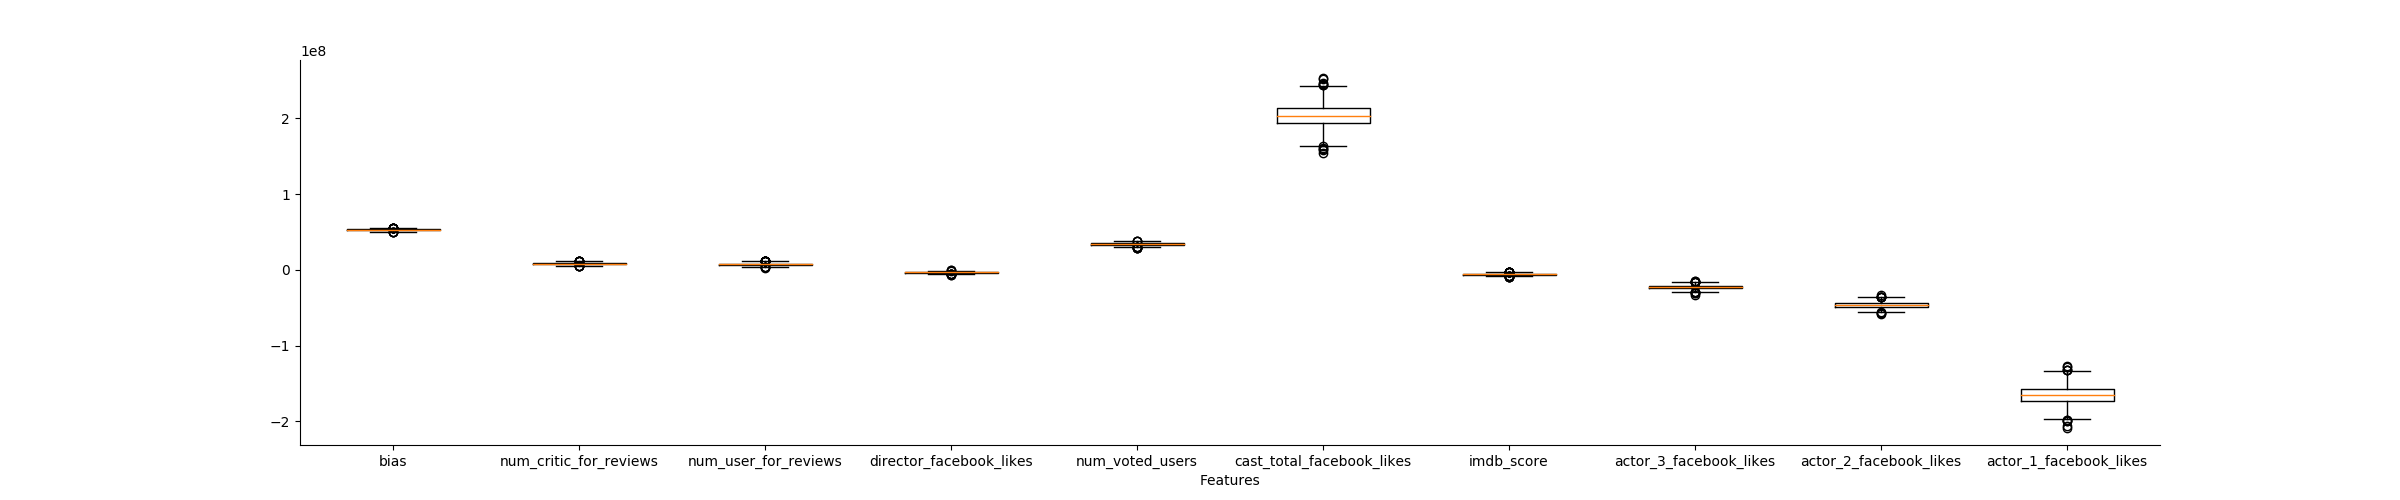

In [11]:
# Plot weights of features
betas_fig = plt.figure(figsize=(24, 5))
ax = betas_fig.add_subplot(111)
ax.boxplot(pooled_model_trace['beta'])
plt.xticks(range(1, len(features)+2), ['bias']+features)
ax.set_xlabel('Features')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

Sorting the weights to order the features according to their importance,

In [12]:
print(np.array(['bias']+features)[np.abs(pooled_model_trace['beta'].mean(axis=0)).argsort()])

['director_facebook_likes' 'imdb_score' 'num_user_for_reviews'
 'num_critic_for_reviews' 'actor_3_facebook_likes' 'num_voted_users'
 'actor_2_facebook_likes' 'bias' 'actor_1_facebook_likes'
 'cast_total_facebook_likes']


It can be seen that the most important features are 'cast_total_facebook_likes' and 'actor_1_facebook_likes'.

Here, we use PSIS-LOO to evaluate the model.

### PSIS-LOO 

[Pareto Smoothed Importance Sampling Leave One Out (PSIS-LOO)](https://arxiv.org/abs/1507.04544) is a recent and robust method for efficient computation of LOO using Pareto Smoothed Importance Sampling (PSIS) which is a new procedure for regularizing importance weights.

In [13]:
# Pareto Smoothed Importance Sampling Leave One Out (PSIS-LOO) Cross Validation
loo, loos, ks = psisloo(pooled_model_trace['log_lik'])
print("Sum of LOO-LPD: {}".format(loo))

Sum of LOO-LPD: -72047.03857947199


<IPython.core.display.Javascript object>


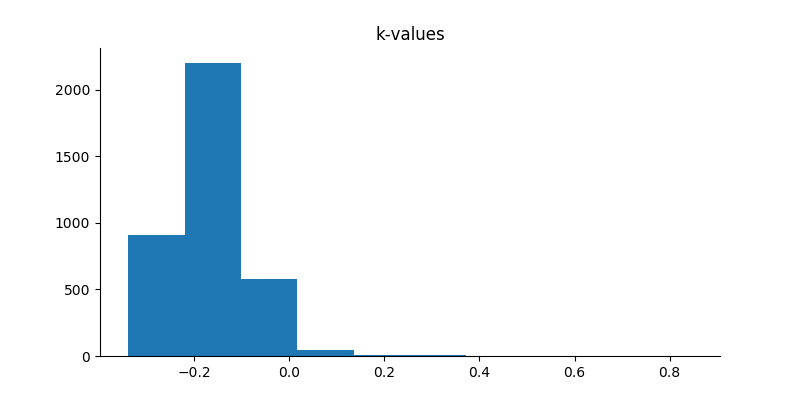

In [14]:
# Plot k-values
k_val_fig = plt.figure(figsize=(8, 4))
ax = k_val_fig.add_subplot(111)
ax.hist(ks)
ax.set_title('k-values')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

All the k-values are below 0.5. So, the model has converged and the PSIS-LOO estimates are reliable.

# Hierarchical Model

In the hierarchical model, the samples are split according to some attribute and samples of each attribute are conditioned on different probability distributions, the parameters of which are conditioned from a common probability distribution. First, we choose language as the attribute to split the data.

In [15]:
# Set hierarchical feature
hier_feature = 'language'

# Convert hierarchical feature to numbers and add to training data 
data[hier_feature] = pd.Categorical(data[hier_feature])
train_data[hier_feature] = data[hier_feature].cat.codes.values + 1
train_data['K'] = train_data[hier_feature].max()

Let us take a look at the distribution of the data when we split it based on language:

In [16]:
data.groupby('language')['gross'].size()

language
Aboriginal       2
Arabic           1
Aramaic          1
Bosnian          1
Cantonese        7
Czech            1
Danish           3
Dari             2
Dutch            3
English       3598
Filipino         1
French          34
German          10
Hebrew           1
Hindi            5
Hungarian        1
Indonesian       2
Italian          7
Japanese        10
Kazakh           1
Korean           5
Mandarin        15
Maya             1
Mongolian        1
None             1
Norwegian        4
Persian          3
Portuguese       5
Romanian         1
Russian          1
Spanish         23
Thai             3
Vietnamese       1
Zulu             1
dtype: int64

It can be seen that the distribution of the data is very skewed and non-centered parametrization is used to avoid the funnel effect. Similar to the pooled model, we generate the code for the stan model according to the choosen features.

In [17]:
# Generate code for hierarchical model
hier_model_code = """
data {
  int<lower=0> N;
  int<lower=0> K;
  int<lower=0> P;\n  """ +\
  ";\n  ".join(["vector[N] {}".format(f) for f in features+[predict_feature]])\
+""";
  int language[N];\n}
parameters {
  real<lower=0> sigma;
  matrix[P, K] beta_raw;
  real<lower=0> beta_mu[P];
  real<lower=0> beta_sigma[P];
}
transformed parameters {
  matrix[P, K] beta;
  vector[N] mu;
  for (p in 1:P)
    beta[p] = beta_mu[p] + beta_raw[p] * beta_sigma[p];
  for (n in 1:N)
    mu[n] = beta[1, language[n]] + """ +\
    " + ".join(["beta[{}, {}[n]]*{}[n]".format(i+2, hier_feature, features[i]) for i in range(len(features))])\
+ """;
}
model {
  for (p in 1:P)
      beta_raw[p] ~ normal(0, 1);
  gross ~ normal(mu, sigma);
}
generated quantities {
  vector[N] log_lik;
  for (n in 1:N)
    log_lik[n] = normal_lpdf(gross[n]|mu[n], sigma);
}
"""
print(hier_model_code)


data {
  int<lower=0> N;
  int<lower=0> K;
  int<lower=0> P;
  vector[N] num_critic_for_reviews;
  vector[N] num_user_for_reviews;
  vector[N] director_facebook_likes;
  vector[N] num_voted_users;
  vector[N] cast_total_facebook_likes;
  vector[N] imdb_score;
  vector[N] actor_3_facebook_likes;
  vector[N] actor_2_facebook_likes;
  vector[N] actor_1_facebook_likes;
  vector[N] gross;
  int language[N];
}
parameters {
  real<lower=0> sigma;
  matrix[P, K] beta_raw;
  real<lower=0> beta_mu[P];
  real<lower=0> beta_sigma[P];
}
transformed parameters {
  matrix[P, K] beta;
  vector[N] mu;
  for (p in 1:P)
    beta[p] = beta_mu[p] + beta_raw[p] * beta_sigma[p];
  for (n in 1:N)
    mu[n] = beta[1, language[n]] + beta[2, language[n]]*num_critic_for_reviews[n] + beta[3, language[n]]*num_user_for_reviews[n] + beta[4, language[n]]*director_facebook_likes[n] + beta[5, language[n]]*num_voted_users[n] + beta[6, language[n]]*cast_total_facebook_likes[n] + beta[7, language[n]]*imdb_score[n] + beta[

Let us now fit the hierarchical model to the data,

In [18]:
hier_model_fit = pystan.stan(model_code=hier_model_code, data=train_data, iter=4000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a85432f1cf5c32c136f89c227b198ace NOW.


Extracting samples from the learned model and printing the model fit,

In [19]:
# Extract samples
hier_model_trace = hier_model_fit.extract()
print(hier_model_fit)

Inference for Stan model: anon_model_a85432f1cf5c32c136f89c227b198ace.
4 chains, each with iter=4000; warmup=2000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=8000.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
sigma           5.1e7  6786.3  6.1e5  5.0e7  5.1e7  5.1e7  5.2e7  5.3e7   8000    1.0
beta_raw[0,0]     0.1    0.01   0.98  -1.82  -0.55   0.11   0.76   2.06   8000    1.0
beta_raw[1,0]    0.06    0.01   0.98  -1.83  -0.61   0.06   0.73   1.95   8000    1.0
beta_raw[2,0]    0.02    0.01   0.99  -1.87  -0.65 7.2e-3    0.7   1.94   8000    1.0
beta_raw[3,0]   -0.01    0.01   0.99  -1.99  -0.68-2.9e-3   0.67   1.94   8000    1.0
beta_raw[4,0] -9.3e-3    0.01   0.98  -1.88  -0.68  -0.02   0.66   1.92   8000    1.0
beta_raw[5,0]   -0.28  9.9e-3   0.89  -1.99  -0.87   -0.3   0.33   1.51   8000    1.0
beta_raw[6,0]   -0.04    0.01   0.99   -2.0  -0.68  -0.05   0.63   1.89   8000    1.0
beta_raw[7,0]   -0.09    0.01   0.99 

All the Rhat values are 1.0 which means that the sampling has completely converged.

Let us now plot the learned bias of each feature in the hierarchical model to see how each attribute of a movie affects it's revenue.

<IPython.core.display.Javascript object>


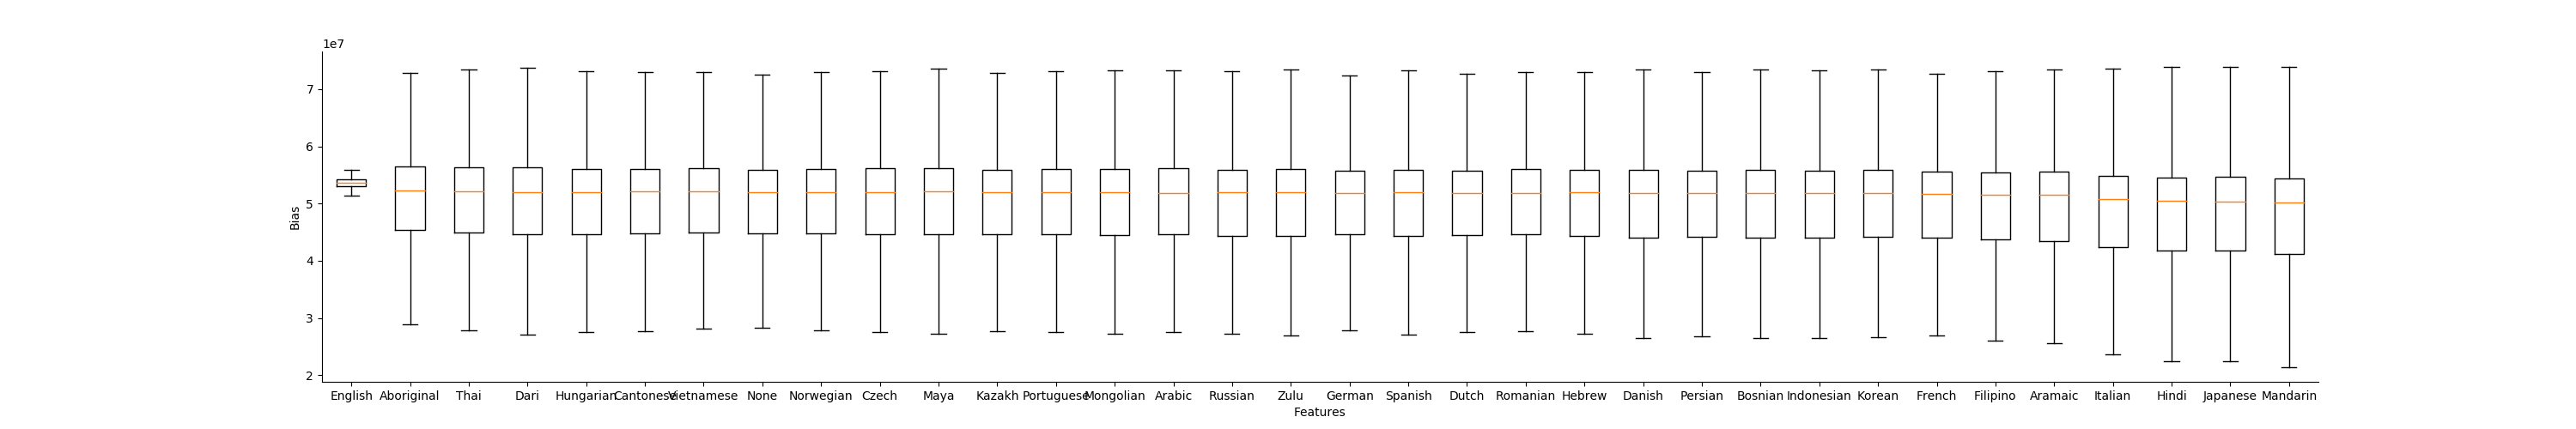

In [20]:
# Plot bias of features
order = hier_model_trace['beta'][:, 0, :].mean(axis=0).argsort()[::-1]
betas_fig = plt.figure(figsize=(30, 5))
ax = betas_fig.add_subplot(111)
ax.boxplot(hier_model_trace['beta'][:, 0, order], 0, '')
plt.xticks(range(1, len(data[hier_feature].cat.categories)+1), data[hier_feature].cat.categories[order])
ax.set_xlabel('Features')
ax.set_ylabel('Bias')
#ax.set_yscale('log')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

To compare with the pooled model, we perform PSIS-LOO cross validation on the hierarchical model.

In [21]:
# Pareto Smoothed Importance Sampling Leave One Out (PSIS-LOO) Cross Validation
loo, loos, ks = psisloo(hier_model_trace['log_lik'])
print("Sum of LOO-LPD: {}".format(loo))

/home/rinu/Documents/aalto/BDA/psis.py:265: RuntimeWarning: overflow encountered in exp
  np.exp(temp, out=temp)


Sum of LOO-LPD: -72041.35530459258


<IPython.core.display.Javascript object>


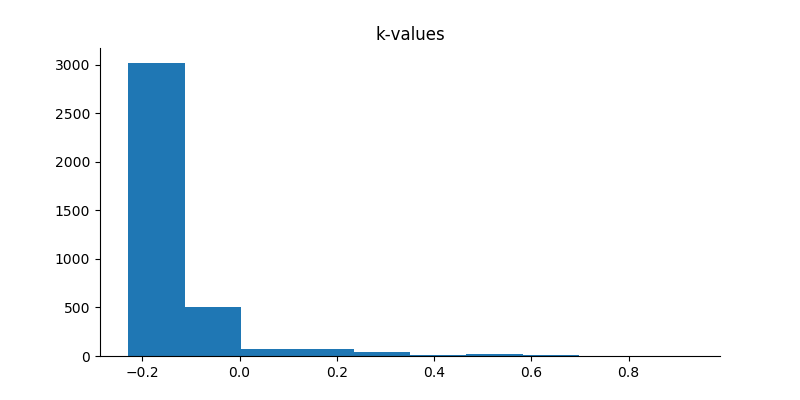

In [22]:
# Plot k-values
k_val_fig = plt.figure(figsize=(8, 4))
ax = k_val_fig.add_subplot(111)
ax.hist(ks)
ax.set_title('k-values')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

Almost all of the k-values are below 0.5. So, the model has converged and the PSIS-LOO estimates are reliable. Since the LOO-LPD value of the hierarchical model is higher than that of the pooled model, the hierarchical model is a better fit for the data. The difference is very small probably because the distribution of the data is skewed when split hierarchically based on language.

Now we fit a similar hierarchical model by splitting the data hierarchically based on country. We follow the exact same steps as described for the above hierarchical model.

In [23]:
# Set hierarchical feature
hier_feature_2 = 'country'

# Convert hierarchical feature to numbers and add to training data 
data[hier_feature_2] = pd.Categorical(data[hier_feature_2])
train_data[hier_feature_2] = data[hier_feature_2].cat.codes.values + 1
train_data['K'] = train_data[hier_feature_2].max()

# Distribution of data based on the hierarchical model
data.groupby(hier_feature_2)['gross'].size()

country
Afghanistan          1
Argentina            3
Aruba                1
Australia           39
Belgium              1
Brazil               5
Canada              59
Chile                1
China               13
Colombia             1
Czech Republic       3
Denmark              8
Finland              1
France             101
Georgia              1
Germany             80
Greece               1
Hong Kong           13
Hungary              2
Iceland              1
India                5
Indonesia            1
Iran                 4
Ireland              7
Israel               1
Italy               11
Japan               15
Mexico               6
Netherlands          3
New Line             1
New Zealand         11
Norway               4
Official site        1
Peru                 1
Poland               1
Romania              2
Russia               3
South Africa         3
South Korea          8
Spain               21
Taiwan               2
Thailand             4
UK                 318
USA

In [24]:
# Generate code for hierarchical model
hier_model_code_2 = """
data {
  int<lower=0> N;
  int<lower=0> K;
  int<lower=0> P;\n  """ +\
  ";\n  ".join(["vector[N] {}".format(f) for f in features+[predict_feature]])\
+""";
  int country[N];\n}
parameters {
  real<lower=0> sigma;
  matrix[P, K] beta_raw;
  real<lower=0> beta_mu[P];
  real<lower=0> beta_sigma[P];
}
transformed parameters {
  matrix[P, K] beta;
  vector[N] mu;
  for (p in 1:P)
    beta[p] = beta_mu[p] + beta_raw[p] * beta_sigma[p];
  for (n in 1:N)
    mu[n] = beta[1, country[n]] + """ +\
    " + ".join(["beta[{}, {}[n]]*{}[n]".format(i+2, hier_feature_2, features[i]) for i in range(len(features))])\
+ """;
}
model {
  for (p in 1:P)
      beta_raw[p] ~ normal(0, 1);
  gross ~ normal(mu, sigma);
}
generated quantities {
  vector[N] log_lik;
  for (n in 1:N)
    log_lik[n] = normal_lpdf(gross[n]|mu[n], sigma);
}
"""
print(hier_model_code_2)


data {
  int<lower=0> N;
  int<lower=0> K;
  int<lower=0> P;
  vector[N] num_critic_for_reviews;
  vector[N] num_user_for_reviews;
  vector[N] director_facebook_likes;
  vector[N] num_voted_users;
  vector[N] cast_total_facebook_likes;
  vector[N] imdb_score;
  vector[N] actor_3_facebook_likes;
  vector[N] actor_2_facebook_likes;
  vector[N] actor_1_facebook_likes;
  vector[N] gross;
  int country[N];
}
parameters {
  real<lower=0> sigma;
  matrix[P, K] beta_raw;
  real<lower=0> beta_mu[P];
  real<lower=0> beta_sigma[P];
}
transformed parameters {
  matrix[P, K] beta;
  vector[N] mu;
  for (p in 1:P)
    beta[p] = beta_mu[p] + beta_raw[p] * beta_sigma[p];
  for (n in 1:N)
    mu[n] = beta[1, country[n]] + beta[2, country[n]]*num_critic_for_reviews[n] + beta[3, country[n]]*num_user_for_reviews[n] + beta[4, country[n]]*director_facebook_likes[n] + beta[5, country[n]]*num_voted_users[n] + beta[6, country[n]]*cast_total_facebook_likes[n] + beta[7, country[n]]*imdb_score[n] + beta[8, count

In [25]:
# Fit the model to data
hier_model_fit_2 = pystan.stan(model_code=hier_model_code_2, data=train_data, iter=4000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_438593b000b9cd4786cedd06d43f84a6 NOW.


In [26]:
# Extract samples
hier_model_trace_2 = hier_model_fit_2.extract()
print(hier_model_fit_2)

Inference for Stan model: anon_model_438593b000b9cd4786cedd06d43f84a6.
4 chains, each with iter=4000; warmup=2000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=8000.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
sigma           5.1e7  6511.0  5.8e5  5.0e7  5.0e7  5.1e7  5.1e7  5.2e7   8000    1.0
beta_raw[0,0]  5.6e-3    0.01   0.98  -1.88  -0.64-3.8e-3   0.66   1.91   8000    1.0
beta_raw[1,0]  1.9e-4    0.01   0.99  -1.95  -0.67-7.0e-3   0.67   1.95   8000    1.0
beta_raw[2,0]   -0.01    0.01   0.98  -1.93  -0.67  -0.01   0.64   1.93   8000    1.0
beta_raw[3,0] -5.9e-3    0.01    1.0  -1.98  -0.69  -0.02   0.68   1.96   8000    1.0
beta_raw[4,0] -8.5e-3    0.01   0.99  -1.96  -0.66-7.9e-3   0.66   1.91   8000    1.0
beta_raw[5,0]   -0.04    0.01   0.93  -1.88  -0.66  -0.04   0.59   1.76   8000    1.0
beta_raw[6,0]    0.01    0.01   0.99  -1.91  -0.67 8.8e-3   0.66   1.99   8000    1.0
beta_raw[7,0] -1.5e-3    0.01   1.01 

<IPython.core.display.Javascript object>


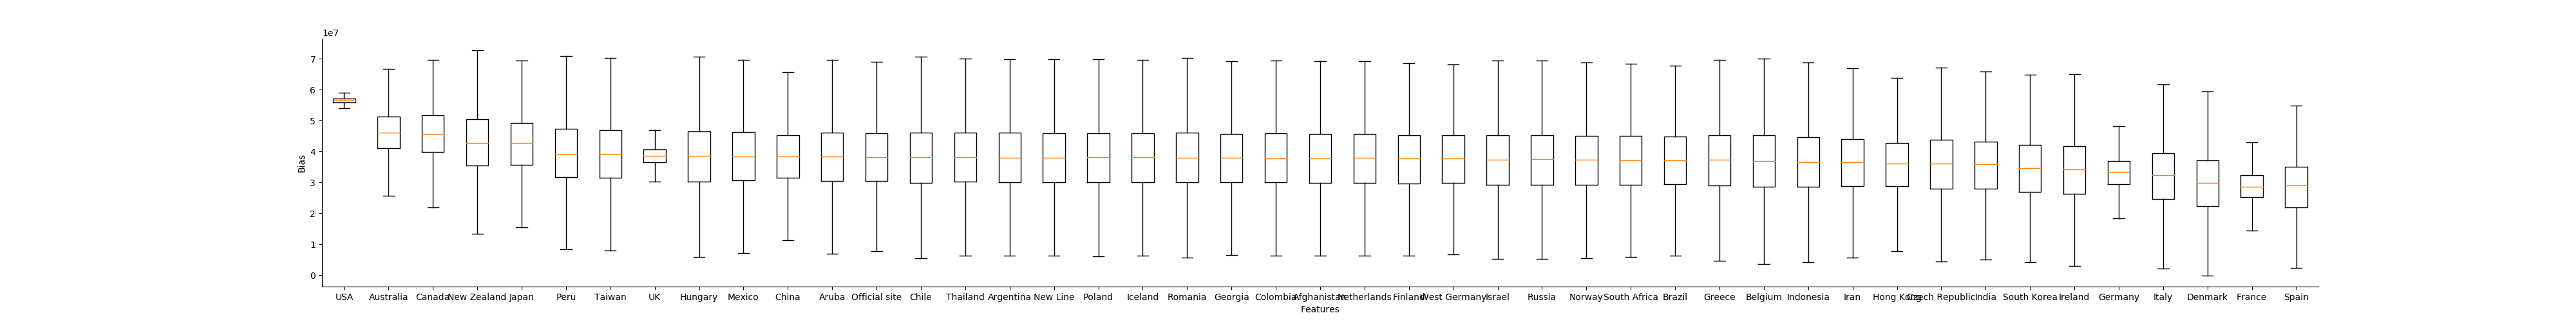

In [27]:
# Plot bias of features
order = hier_model_trace_2['beta'][:, 0, :].mean(axis=0).argsort()[::-1]
betas_fig = plt.figure(figsize=(40, 5))
ax = betas_fig.add_subplot(111)
ax.boxplot(hier_model_trace_2['beta'][:, 0, order], 0, '')
plt.xticks(range(1, len(data[hier_feature_2].cat.categories)+1), data[hier_feature_2].cat.categories[order])
ax.set_xlabel('Features')
ax.set_ylabel('Bias')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [28]:
# Pareto Smoothed Importance Sampling Leave One Out (PSIS-LOO) Cross Validation
loo, loos, ks = psisloo(hier_model_trace_2['log_lik'])
print("Sum of LOO-LPD: {}".format(loo))

/home/rinu/Documents/aalto/BDA/psis.py:265: RuntimeWarning: overflow encountered in exp
  np.exp(temp, out=temp)


Sum of LOO-LPD: -72020.30197731542


<IPython.core.display.Javascript object>


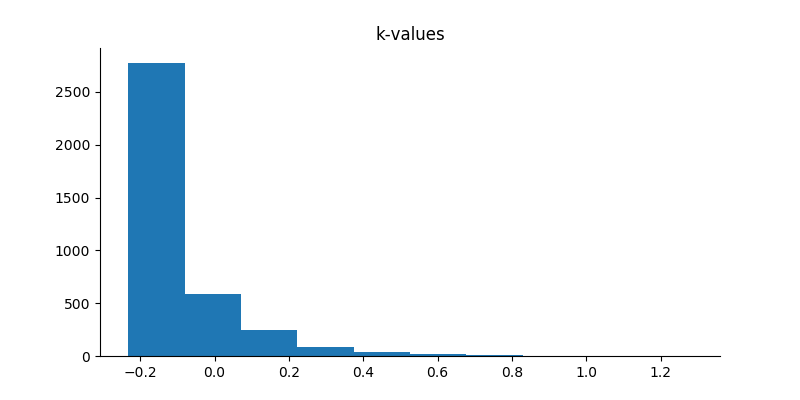

In [29]:
# Plot k-values
k_val_fig = plt.figure(figsize=(8, 4))
ax = k_val_fig.add_subplot(111)
ax.hist(ks)
ax.set_title('k-values')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

Almost all the k-values are below 0.5. So, the model has converged and the PSIS-LOO estimates are reliable. Since the LOO-LPD value of the hierarchical model based on country is higher than that of the hierarchical model based on language, the hierarchical model based on country is a better fit for the data.

# Conclusion

In this notebook, we used the PyStan library to fit pooled and hierarchical bayesian linear regression models to the IMDB 5000 movie dataset to predict the gross of a movie based on it's other attributes. Using PSIS-LOO cross validation we found that a hierarchical model based on country is the best fit for the data.